The following notebooks help in creating ensemble of LightGBM and Catboost however I didn't seem to find massive improvement , PUBLIC LB:0.758
References 
https://www.kaggle.com/shinomoriaoshi/riiid-catboost-baseline
https://www.kaggle.com/shoheiazuma/riiid-lgbm-starter

# Use the package 'datatable' for fast handling

In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

# Necessary packages

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
import riiideducation
import torch

# Error handling, ignore all
np.seterr(divide = 'ignore', invalid = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Preprocessing

* Data config

In [3]:
data_types_dict = {
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}

target = 'answered_correctly'

* Import data

In [4]:
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns = set(data_types_dict.keys())).to_pandas()

* Information of the training dataset

In [5]:
# Exclude lectures
train_df = train_df[train_df[target] != -1].reset_index(drop = True, inplace = False)
# Fill NaN values in the 'prior_question_had_explanation' columns
train_df['prior_question_had_explanation'].fillna(False, inplace = True)
# Set type
train_df = train_df.astype(data_types_dict)

* Construct new features

In [6]:
# Answer for the previous questions of users
train_df['lag'] = train_df.groupby('user_id')[target].shift()
# For each user (groupby('user_id')), compute the cummulative number of correct answers and number answers in general
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
# User correctness (measure the users' learning progress)
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
# Drop the 'lag' feature
train_df.drop(columns = ['lag'], inplace = True)

In [7]:
# Overall correctness of users
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
                                                                               
# Overall difficulty of questions
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

In [8]:
# Take only 24 last observations of each user
train_df = train_df.groupby('user_id').tail(24).reset_index(drop = True)

In [9]:
train_df

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness
0,115,45,0,19000.0,False,0.727273
1,115,185,0,21000.0,False,0.695652
2,115,55,1,22000.0,False,0.666667
3,115,7876,1,16000.0,False,0.680000
4,115,6,1,20000.0,False,0.692308
...,...,...,...,...,...,...
8897654,2147482888,3586,1,18000.0,True,0.500000
8897655,2147482888,6341,1,14000.0,True,0.521739
8897656,2147482888,4212,1,14000.0,True,0.541667
8897657,2147482888,6343,0,22000.0,True,0.560000


* Question dataset comes into play

In [10]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols = [0, 3],
    dtype = {'question_id': 'int16', 'part': 'int8'}
)
train_df = pd.merge(train_df, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')
train_df.drop(columns = ['question_id'], inplace = True)

In [11]:
# How many questions have been answered in each content ID?
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
# How hard are questions in each content ID?
train_df['content_id'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

# Extract the validation set

In [12]:
# Ratio is 6/24 = 25%
valid_df = train_df.groupby('user_id').tail(6)
train_df.drop(valid_df.index, inplace = True)

# Training

* Construct data

In [13]:
features = ['content_id', 'prior_question_elapsed_time', 
            'prior_question_had_explanation', 'user_correctness', 
            'part', 'content_count']

params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
    'grow_policy': 'Lossguide',
    'iterations': 1000,#2500
    'learning_rate': 4e-3,
    'random_seed': 0,
    'l2_leaf_reg': 1e-1,
    'depth': 15,
    'max_leaves': 13,
    'border_count': 128,
    'verbose': 50,
}

params1 = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 85
}

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.751685	valid_1's auc: 0.734183
[100]	training's auc: 0.753122	valid_1's auc: 0.735811
[150]	training's auc: 0.753759	valid_1's auc: 0.736343
[200]	training's auc: 0.754086	valid_1's auc: 0.736519
[250]	training's auc: 0.754374	valid_1's auc: 0.736665
[300]	training's auc: 0.75464	valid_1's auc: 0.736793
[350]	training's auc: 0.754866	valid_1's auc: 0.736868
[400]	training's auc: 0.755093	valid_1's auc: 0.73695
[450]	training's auc: 0.75532	valid_1's auc: 0.737028
[500]	training's auc: 0.75554	valid_1's auc: 0.737096
[550]	training's auc: 0.755734	valid_1's auc: 0.73715
[600]	training's auc: 0.755934	valid_1's auc: 0.737194
[650]	training's auc: 0.756148	valid_1's auc: 0.737247
[700]	training's auc: 0.756349	valid_1's auc: 0.737281
[750]	training's auc: 0.756532	valid_1's auc: 0.737309
[800]	training's auc: 0.75671	valid_1's auc: 0.737333
[850]	training's auc: 0.756908	valid_1's auc: 0.737361
[900]	train

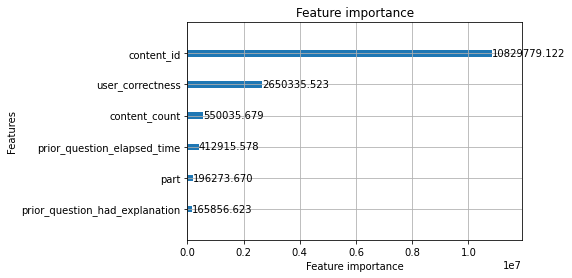

In [14]:
tr_data = lgb.Dataset(train_df[features], label=train_df[target])
va_data = lgb.Dataset(valid_df[features], label=valid_df[target])

model1 = lgb.train(
    params1, 
    tr_data, 
    num_boost_round=10000,
    valid_sets=[tr_data, va_data], 
    early_stopping_rounds=50,
    verbose_eval=50
)

# model.save_model(f'model.txt')
lgb.plot_importance(model1, importance_type='gain')
plt.show()

In [15]:
from catboost import CatBoostClassifier, Pool

# Training and validating data
train_set = Pool(train_df[features], label = train_df[target])
val_set = Pool(valid_df[features], label = valid_df[target])

In [16]:
# Model definition
model = CatBoostClassifier(**params)

# Fitting
model.fit(train_set, eval_set = val_set, use_best_model = True)

0:	test: 0.6986691	best: 0.6986691 (0)	total: 8.62s	remaining: 2h 23m 29s
50:	test: 0.7178314	best: 0.7178314 (50)	total: 6m 23s	remaining: 1h 58m 47s
100:	test: 0.7192818	best: 0.7192818 (100)	total: 12m 36s	remaining: 1h 52m 16s
150:	test: 0.7205544	best: 0.7205544 (150)	total: 18m 55s	remaining: 1h 46m 24s
200:	test: 0.7215081	best: 0.7215091 (199)	total: 25m 15s	remaining: 1h 40m 25s
250:	test: 0.7225292	best: 0.7225292 (250)	total: 31m 33s	remaining: 1h 34m 11s
300:	test: 0.7233748	best: 0.7233748 (300)	total: 37m 59s	remaining: 1h 28m 12s
350:	test: 0.7241105	best: 0.7241105 (350)	total: 44m 21s	remaining: 1h 22m 1s
400:	test: 0.7247828	best: 0.7247828 (400)	total: 50m 46s	remaining: 1h 15m 51s
450:	test: 0.7254445	best: 0.7254445 (450)	total: 57m 15s	remaining: 1h 9m 42s
500:	test: 0.7260955	best: 0.7260955 (500)	total: 1h 3m 41s	remaining: 1h 3m 26s
550:	test: 0.7266996	best: 0.7266996 (550)	total: 1h 10m 19s	remaining: 57m 18s
600:	test: 0.7273183	best: 0.7273183 (600)	total: 

# Inference

In [17]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

In [18]:
try:
    env = riiideducation.make_env()
except:
    pass
iter_test = env.iter_test()
prior_test_df = None

In [19]:
%%time

for (test_df, sample_prediction_df) in iter_test:
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop = True)
        
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        
        for user_id, content_id, answered_correctly in zip(user_ids, content_ids, targets):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1

    prior_test_df = test_df.copy()
    
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop = True)
    test_df = pd.merge(test_df, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('bool')    
    
    user_sum = np.zeros(len(test_df), dtype = np.int16)
    user_count = np.zeros(len(test_df), dtype = np.int16)
    content_sum = np.zeros(len(test_df), dtype = np.int32)
    content_count = np.zeros(len(test_df), dtype = np.int32)
    
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]

    test_df['user_correctness'] = user_sum / user_count
    test_df['content_count'] = content_count
    test_df['content_id'] = content_sum / content_count
       
    test_df[target] = np.average([
        model.predict_proba(test_df[features].values)[:,1],
        model1.predict(test_df[features])
    ], weights=[0.49934,0.50066], axis=0)
    env.predict(test_df[['row_id', target]])

CPU times: user 564 ms, sys: 57.8 ms, total: 622 ms
Wall time: 690 ms
